In [ ]:
# Jackknife and bootstrap sampling 

In [1]:
import numpy as np
np.random.seed(210187)

x = np.random.normal( size=500 )

# let's investigate use of sample mean and variance
print(np.mean(x))
print(np.var(x))

0.014153195911253903
1.1006076845524735


- Can ask the [resample](https://resample.readthedocs.io/en/stable/index.html) package to simply provide **bootstrap** and **jackknife** samples themselves
- To avoid memory overruns they will return generators rather than very large arrays

In [2]:
from resample import bootstrap, jackknife

bstrp = np.array( [ b for b in bootstrap.resample(x, size=1000) ] )
jknif = np.array( [ j for j in jackknife.resample(x) ] )

print(x.shape)
print(bstrp.shape)
print(jknif.shape)


(500,)
(1000, 500)
(500, 499)


- Can also ask [resample](https://resample.readthedocs.io/en/stable/index.html) to provide biases or estimates directly

In [3]:
b_bias = bootstrap.bias( np.var, x, size=5000 )
print(b_bias)

j_bias = jackknife.bias( np.var, x )
print(j_bias)

-0.0021815918356389297
-0.0022056266222025833


In [4]:
b_est = bootstrap.bias_corrected( np.var, x, size=5000 )
print(b_est)

j_est = jackknife.bias_corrected( np.var, x )
print(j_est)

print( np.var(x) )
print( np.var(x, ddof=1) )

1.1028766915595887
1.1028133111747138
1.1006076845524735
1.1028133111748233


- and indeed it can provide confidence intervals as well with either
    - percentile
    - BCa

In [5]:
from scipy.stats import chi2

theta = jackknife.bias_corrected( np.var, x )
theta_l, theta_h = bootstrap.confidence_interval( np.var, x, size=5000, cl=chi2.cdf(1,1), ci_method='bca') 
theta_e = (theta_h - theta_l)/2

N = len(x)

sample_var_corr = np.var(x, ddof=1)
sample_var_corr_err = np.sqrt( 2*np.var(x,ddof=1)**2/(N-1) )

print( f'Standard Sample Estimate:  {sample_var_corr:5.3f} +/- {sample_var_corr_err:5.3f}'  )
print( f'Bootstrapped BCa interval: {theta:5.3f} +/- {theta_e:5.3f}'  )

Standard Sample Estimate:  1.103 +/- 0.070
Bootstrapped BCa interval: 1.103 +/- 0.068


In [6]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('mphil.mplstyle')
from scipy.stats import truncnorm, truncexpon
from iminuit import Minuit, cost

# set the seed for reproducibility
np.random.seed(21187)

# setup the model

# model parameters
xrange = (100,150)
Ns = 450
Nb = 900
mu = 125
sg = 3
p  = 0.04
names = [ 'N_s', '\mu', '\sigma', 'N_b', 'p' ]

# the model functions
def bkg_model(p):
    endp = (xrange[1]-xrange[0])*p
    srtp = xrange[0]
    scl  = 1/p
    return truncexpon(b=endp, loc=srtp, scale=scl)

def sig_model(mu, sg):
    a, b = (xrange[0]-mu)/sg, (xrange[1]-mu)/sg
    return truncnorm(a=a, b=b, loc=mu, scale=sg)

def tot_model(x, Ns, mu, sg, Nb, p):
    return Ns*sig_model(mu,sg).pdf(x) + Nb*bkg_model(p).pdf(x)

def tot_density(x, Ns, mu, sg, Nb, p):
    return Ns+Nb, tot_model(x, Ns, mu, sg, Nb, p)

# a generate function
def generate(Ns, mu, sg, Nb, p):

    # generate poisson number of events first
    Ns = np.random.poisson(Ns)
    Nb = np.random.poisson(Nb)

    # then generate from the model
    b = bkg_model(p)
    s = sig_model(mu,sg)

    bkg = b.rvs( size=Nb )
    sig = s.rvs( size=Ns )

    return np.concatenate( [bkg, sig] )

# a fit function
def fit(dset):
    n2ll = cost.ExtendedUnbinnedNLL( dset, tot_density )
    mi = Minuit( n2ll, Ns=450, mu=125, sg=3, Nb=900, p=0.04 )
    mi.limits['Ns','Nb'] = (0,2000)
    mi.limits['mu'] = (110,140)
    mi.limits['sg'] = (0,10)
    mi.limits['p'] = (0,1)
    mi.migrad()
    mi.hesse()
    return mi

# a plot function
def plot(xvals, ax=None):
    ax = ax or plt.gca()
    # compute mean, sdev and their errors of distribution
    m = np.mean(xvals)
    s = np.std(xvals, ddof=1)
    me = s/len(xvals)**0.5
    se = s/(2*len(xvals)-1)**0.5
    # make a density histogram
    nh, xe = np.histogram( xvals, range=(m-3*s,m+3*s), bins='auto', density=True )
    # draw the density histogram
    ax.hist( xvals, bins=xe, density=True, alpha=0.5 )
    # also draw error bars on points
    N = np.sum(nh)/len(xvals)
    cx = 0.5*(xe[1:]+xe[:-1])
    ax.errorbar( cx, nh, N*(nh/N)**0.5, fmt='ko' )
    # draw the normal distribution with the mean and sigma
    x = np.linspace(xe[0],xe[-1],100)
    ax.plot(x, norm.pdf(x,m,s), 'r-')
    # plot the results (use uncertainties package for nice formatting)
    um = uncert.ufloat( m, me )
    us = uncert.ufloat( s, se )
    mstr = f"{um:.1u}".replace("+/-","\pm")
    sstr = f"{us:.1u}".replace("+/-","\pm")
    ax.text(0.01,0.92, f"$\hat{{\mu}} = {mstr}$", transform=ax.transAxes)
    ax.text(0.01,0.86, f"$\hat{{\sigma}} = {sstr}$", transform=ax.transAxes)

## 0. let's do a dummy generation to get ourselves the "real" data
data = generate(Ns, mu, sg, Nb, p)

## 1. now let's fit the data
# this gives us the fit values for our ensemble generation
mi = fit(data)

nom_vals = list(mi.values)
nom_errs = list(mi.errors)

Text(0, 0.5, 'Events / GeV')

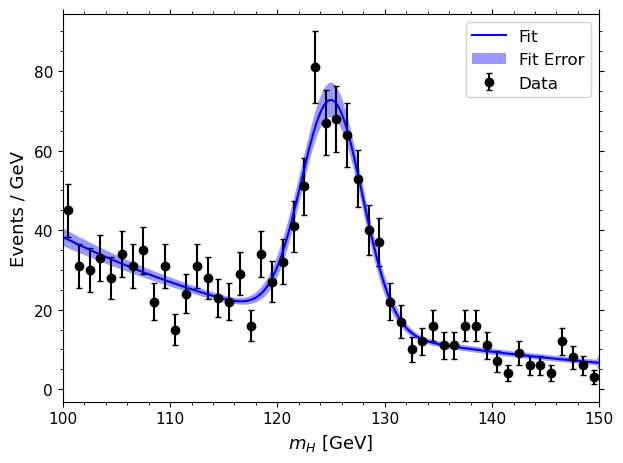

In [7]:
# generate 1000 bootstrapped values
bootstrap_pars = np.random.multivariate_normal( mi.values, mi.covariance, size=1000)

# draw the pdf and the bootstrapped error
x = np.linspace(*xrange,200)
y = tot_model(x, *mi.values)
y_boot = [ tot_model(x, *p) for p in bootstrap_pars ]
yerr_boot = np.std( y_boot, axis=0 )
  
fig, ax = plt.subplots()
nh, xe = np.histogram(data, range=xrange, bins=50)
cx = 0.5*(xe[:-1]+xe[1:])
ax.errorbar( cx, nh, nh**0.5, fmt='ko', label='Data' )
ax.plot(x, y, 'b-', label='Fit')
ax.fill_between(x, y-yerr_boot, y+yerr_boot, fc='b', alpha=0.4, label='Fit Error')

ax.legend()
ax.set_xlim(*xrange)
bw = xe[1]-xe[0]
ax.set_xlabel('$m_H$ [GeV]')
ax.set_ylabel(f'Events / GeV')

In [8]:
## Define alternate fit to data
from scipy.stats import powerlaw, truncpareto

# an alternate background model
def alt_bkg_model(p):
    scale = p
    loc = xrange[0]-scale
    c = ( xrange[1] - xrange[0] + scale ) / scale
    return truncpareto(b=1, c=c, loc=loc, scale=scale)

def alt_tot_model(x, Ns, mu, sg, Nb, p):
    return Ns*sig_model(mu,sg).pdf(x) + Nb*alt_bkg_model(p).pdf(x)

def alt_tot_density(x, Ns, mu, sg, Nb, p):
    return Ns+Nb, alt_tot_model(x, Ns, mu, sg, Nb, p)

# a generate function
def alt_generate(Ns, mu, sg, Nb, p):

    # generate poisson number of events first
    Ns = np.random.poisson(Ns)
    Nb = np.random.poisson(Nb)

    # then generate from the model
    b = alt_bkg_model(p)
    s = sig_model(mu,sg)

    bkg = b.rvs( size=Nb )
    sig = s.rvs( size=Ns )

    return np.concatenate( [bkg, sig] )

# a fit function
def alt_fit(dset):
    n2ll = cost.ExtendedUnbinnedNLL( dset, alt_tot_density )
    mi = Minuit( n2ll, Ns=450, mu=125, sg=3, Nb=900, p=8 )
    mi.limits['Ns','Nb'] = (0,2000)
    mi.limits['mu'] = (110,140)
    mi.limits['sg'] = (0,10)
    mi.limits['p'] = (0,100)
    mi.migrad()
    mi.hesse()
    return mi

alt_mi = alt_fit( data )
display(alt_mi)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -6480                      │              Nfcn = 188              │
│ EDM = 4.68e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Ns   │    424    │    29     │            │            │    0    │  2000   │       │
│ 1 │ mu   │  125.01   │   0.21    │            │            │   110   │   140   │       │
│ 2 │ sg   │   2.96    │   0.21    │            │            │    0    │   10    │       │
│ 3 │ Nb   │    890    │    40     │            │            │    0    │  2000   │       │
│ 4 │ p    │    38     │     4     │            │            │    0    │   100   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬──────────────────────────────────────────────┐
│    │       Ns       mu       sg       Nb        p │
├────┼──────────────────────────────────────────────┤
│ Ns │      872    -0.63     2.84   -0.4e3      -36 │
│ mu │    -0.63   0.0439    -0.01     0.63    -0.02 │
│ sg │     2.84    -0.01   0.0459    -2.84    -0.21 │
│ Nb │   -0.4e3     0.63    -2.84 1.33e+03       36 │
│  p │      -36    -0.02    -0.21       36     17.4 │
└────┴──────────────────────────────────────────────┘

In [ ]:
# now bootstrap from here
from tqdm import tqdm
ntoys = 250
gen_vals = list(alt_mi.values)
fit_diff = []
for i in tqdm(range(ntoys)):
    alt_toy = alt_generate(*gen_vals)
    alt_mi = alt_fit(alt_toy)
    nom_mi = fit(alt_toy)
    if alt_mi.valid and nom_mi.valid:
        fit_diff.append( np.array(nom_mi.values) - np.array(alt_mi.values) )
    
fit_diff = np.asarray(fit_diff)


 62%|██████████████████████████████████████████████████████████████████████                                           | 155/250 [00:34<00:20,  4.59it/s]

In [ ]:
from scipy.stats import norm

fig, axes = plt.subplots(2, 2, figsize=(12.8, 9.6))
for (i, par), ax in zip( enumerate(['Ns','mu','sg','Nb']), axes.flatten() ):
    
    ax.hist( fit_diff[:,i], density=True, bins=50)
    ax.axvline(0, c='k')
    ax.axvline(nom_errs[i], c='g', ls='--', label='Stat Error')
    ax.axvline(np.mean(fit_diff[:,i]), c='r', ls='--', label='Syst Error')
    ax.set_xlabel(par)
    ax.legend()
